In [ ]:
from google.colab import files
uploaded = files.upload()

Saving файл 1.txt to файл 1.txt


In [ ]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

Загрузим файл, переведём его в dataframe и посмотрим на основную информацию о столбцах, также посмортим на саму таблицу

In [ ]:
def get_df(dir):
    df = pd.read_csv(dir, sep='\t', header=0, skipinitialspace=True)
    return df

workdir = Path(os.getcwd())
df = get_df(workdir/'файл 1.txt')
print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   login        701827 non-null  object 
 1   tid          701827 non-null  float64
 2   Microtasks   701827 non-null  float64
 3   assigned_ts  701827 non-null  object 
 4   closed_ts    701827 non-null  object 
dtypes: float64(2), object(3)
memory usage: 26.8+ MB
None
    login          tid  Microtasks          assigned_ts            closed_ts
0  login0  190563850.0         4.0  2017-04-20 12:09:39  2017-04-20 13:13:01
1  login0  190561754.0         1.0  2017-04-20 12:10:30  2017-04-20 12:28:29
2  login0  190565906.0         4.0  2017-04-20 12:21:31  2017-04-20 13:30:10
3  login0  190560246.0         1.0  2017-04-20 12:28:30  2017-04-20 13:13:56
4  login0  190562168.0         2.0  2017-04-20 12:28:42  2017-04-20 13:14:50


Нужно перевести колонки assigned_ts и closed_ts в формат datetime

In [ ]:
format = '%Y-%m-%d %H:%M:%S.%f'
df['assigned_ts'] = pd.to_datetime(df['assigned_ts'], format=format)
df['closed_ts'] = pd.to_datetime(df['closed_ts'], format=format)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   login        701827 non-null  object        
 1   tid          701827 non-null  float64       
 2   Microtasks   701827 non-null  float64       
 3   assigned_ts  701827 non-null  datetime64[ns]
 4   closed_ts    701827 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 26.8+ MB
None


Проверим есть ли строки с одинаковым task_id, внутри которых можно вычислять статистики

171470568.0    134
188676794.0    118
195476986.0     96
196322338.0     86
171266128.0     85
              ... 
196591532.0      1
169656678.0      1
192747426.0      1
193420012.0      1
165647344.0      1
Name: tid, Length: 635044, dtype: int64


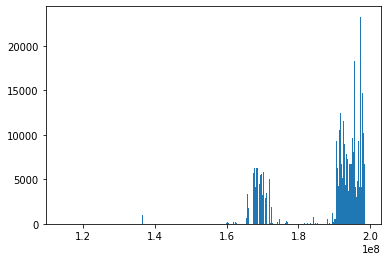

In [ ]:
print(df['tid'].value_counts())
plt.hist(df['tid'], bins=int(len(df['tid']) * 0.001))
plt.show()

Создадим колонку delta. В неё для каждой строки запишем время, прошедшее между выдачей и сдачей задания и разделим на количество микрозаданий в задании. Таким образом, в столбце delta находится среднее время выполнения одного микрозадания в задании (если микрозаданий >2).

In [ ]:
df['delta'] = (df['closed_ts'] - df['assigned_ts']) / df['Microtasks']
df['delta'] = df['delta'].astype('timedelta64[s]')
print(df)

           login          tid  ...           closed_ts   delta
0         login0  190563850.0  ... 2017-04-20 13:13:01   950.0
1         login0  190561754.0  ... 2017-04-20 12:28:29  1079.0
2         login0  190565906.0  ... 2017-04-20 13:30:10  1029.0
3         login0  190560246.0  ... 2017-04-20 13:13:56  2726.0
4         login0  190562168.0  ... 2017-04-20 13:14:50  1384.0
...          ...          ...  ...                 ...     ...
701822  login766  195656026.0  ... 2017-05-15 16:16:56  1409.0
701823  login766  195656174.0  ... 2017-05-15 16:21:53  1700.0
701824  login766  195656466.0  ... 2017-05-15 16:23:41  1803.0
701825  login766  195656336.0  ... 2017-05-15 16:32:11   757.0
701826  login766  195656078.0  ... 2017-05-15 16:17:32   676.0

[701827 rows x 6 columns]


Посмотрев на основные статистики, я вижу, что минимальное значение отрицательно. Это значит, что есть записи, где задание сделано раньше, чем выдано.

In [ ]:
print(df['delta'].describe())

count    7.018270e+05
mean     5.679706e+02
std      5.378995e+03
min     -7.290000e+02
25%      3.700000e+01
50%      7.500000e+01
75%      1.820000e+02
max      1.074156e+06
Name: delta, dtype: float64


Удостоверимся, что это случайная ошибка, посчитав кол-во записей, где delta отрицательная.

In [ ]:
print(len(df.loc[df['delta'] < 0]))

1


# Метод №1 (основан на личных предположениях)

Возьмём строки с положительными значениями delta и посмотрим на статистики. Видим, что среднее в три раза больше квантиля 75-ого порядка, а среднеквадратическое отклонение больше на порядок. Это говорит о том, что есть небольшей процент ассесоров, которые очень долго выполняют микрозадания. На первом этапе нужно предположить минимальное количество микрозаданий, которые выполняются за время delta. Я предположу, что только 25% заданий реально выполняются за время delta. Таким образом, нужно найти квантиль 25-ого порядка и посмотреть среднее время выполнения микрозадания.
Квантиль 25-ого порядка равен 37 секунд, это значит, что 25% микрозаданий выполняються менее, чем за 37 секунд.

In [ ]:
df = df.loc[df['delta'] > 0]
print(df['delta'].describe())

count    7.018260e+05
mean     5.679724e+02
std      5.378998e+03
min      1.000000e+00
25%      3.700000e+01
50%      7.500000e+01
75%      1.820000e+02
max      1.074156e+06
Name: delta, dtype: float64


Теперь возьмем все записи, где delta меньше 37 секунд и посмотрим на статистики. Среднее значение равно 23 секунды. Исходя из своих личных предположений, я бы считал стоимость одного микрозадания как 23*N/30.


In [ ]:
print(df.loc[df['delta'] < 37]['delta'].describe())

count    173747.000000
mean         23.099691
std           8.013615
min           1.000000
25%          17.000000
50%          23.000000
75%          30.000000
max          36.000000
Name: delta, dtype: float64


# Метод №2 (основан на личных предположениях)

Постараемся учесть влияние конкретных ассесоров, сгруппировав delta по колонке login. Допустим, что каждый ассесор 25% микрозаданий выполняет точно за время delta. Посчитаем квантиль 25-ого порядка для каждого ассесора. Выведем статистики. Допустим, что 25%
ассеров точно выполняют 25% микрозаданий за время delta. Таким образом, повторно возьмем квантиль 25-ого порядка.

In [ ]:
group_login = df.groupby('login', as_index=False)['delta']
average = group_login.quantile(q=0.25)['delta']
print(average.describe())

count      767.000000
mean       147.340613
std       1048.766541
min         12.000000
25%         38.000000
50%         57.000000
75%         94.000000
max      28263.000000
Name: delta, dtype: float64


Теперь возьмем все записи, где delta меньше 38 секунд и посмотрим на статистики. Среднее значение рано 23.5 секунды. Исходя из своих личных предположений, я бы считал стоимость одного микрозадания как 23.5*N/30.


In [ ]:
print(df.loc[df['delta'] < 38]['delta'].describe())

count    179701.000000
mean         23.560247
std           8.263177
min           1.000000
25%          17.000000
50%          24.000000
75%          30.000000
max          37.000000
Name: delta, dtype: float64


# Метод №3 

Посторим график средних времен выполнения одного микрозадания для верхних границ в диапазоне от 10 до 1000 секунд. Примерно после 40 секунд производная среднего значения по верхней границе заметно падает. Это значит, что после 40 секунд начинаются выбросы. Можно установить стоимость выполнения одного микрозадания, как 40*N/30.

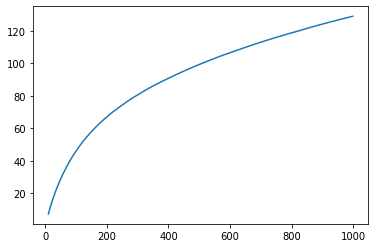

In [ ]:
x, y = [], []
for i in range(10, 1000):
  x.append(i)
  y.append(df.loc[df['delta'] < i]['delta'].mean())
plt.plot(x, y)

Посмотрим на количество выполнения одного и того же задания разными людьми.

In [ ]:
val_count = df['tid'].value_counts()
print(val_count)

171470568.0    134
188676794.0    118
195476986.0     96
196322338.0     86
171266128.0     85
              ... 
196591532.0      1
169656678.0      1
192747426.0      1
193420012.0      1
165647344.0      1
Name: tid, Length: 635044, dtype: int64


На статистиках ниже можно увидеть, что сами задания можно дифференцировать по времени. Какие-то выполняються дольше, какие-то быстрее. 

In [ ]:
print(df.loc[df['tid'] == 171470568.0]['delta'].describe())

count      134.000000
mean      2133.320896
std       5901.356344
min          9.000000
25%         42.250000
50%         92.000000
75%        428.750000
max      31834.000000
Name: delta, dtype: float64


In [ ]:
print(df.loc[df['tid'] == 188676794.0]['delta'].describe())

count      118.000000
mean      1492.864407
std       2943.704753
min          8.000000
25%         41.000000
50%        117.500000
75%       1067.500000
max      10748.000000
Name: delta, dtype: float64


In [ ]:
print(df.loc[df['tid'] == 195476986.0]['delta'].describe())

count       96.000000
mean       945.958333
std       1994.316967
min         25.000000
25%         69.750000
50%        194.500000
75%        911.500000
max      12156.000000
Name: delta, dtype: float64


In [ ]:
print(df.loc[df['tid'] == 171266128.0]['delta'].describe())

count       85.000000
mean       972.823529
std       3126.989421
min          2.000000
25%         22.000000
50%         41.000000
75%        158.000000
max      15906.000000
Name: delta, dtype: float64


Ниже можно посмотреть среднии значения статистик для топ-15 заданий по количеству повторов.

In [ ]:
idx = val_count.index
num = 15
for i in range(num):
  stat = df.loc[df['tid'] == idx[i]]['delta'].describe()
  if i > 0:
    stat += stat
  else:
    pass
print(stat/num)

count    10.533333
mean     16.291983
std      15.011533
min       1.333333
25%       6.000000
50%      12.000000
75%      20.866667
max      82.533333
Name: delta, dtype: float64


# Метод №4

Для каждого задания, для которого есть больше 30 записей в таблице, расчитаем квантиль порядка 25 и посмотрим на среднее. Таким образом, в каждом задании для которого есть 30 значений найдём оптимальное время в которое укладываются 25% ассесоров и посчитаем среднее по этим временам.
Этот подход, по моему мнению, наилучший. Итого 58*N/30

In [ ]:
group_tid = df.groupby('tid', as_index=False)['delta']
new_df = group_tid.count()['delta']
new_df = group_tid.quantile(q=0.25).loc[new_df > 30]
print(new_df.describe()['delta'])

count    107.000000
mean      57.593458
std       25.674039
min       20.000000
25%       41.000000
50%       50.000000
75%       69.250000
max      170.000000
Name: delta, dtype: float64


# Вывод
На мой взгляд, только подход №3 в полной мере может убрать влияние индивидуальных челевоческих особеностей работы и усреднить сложность заданий. Чтобы уменьшить ошибку я бы взял среднее по методам №2, 3, 4. Итого стоимость одного микрозадания 40*N/30 = 1.33N. 